**<h1>Optimization using the Binary Genetic Algorithm</h1>**
<h3> Presentation by Asimakis Kydros, 3881 </h3>

In [91]:
author = 'Ασημάκης Κύδρος'
srn = 3881
email = 'asimakis@csd.auth.gr'

Libraries used are listed below

In [92]:
from typing import Callable
from random import getrandbits, uniform, randint, seed  
from sklearn.model_selection import train_test_split
from textwrap import wrap
from numpy import std
import matplotlib.pyplot as plt

<h3>$Abstract$</h3>

The Binary Genetic Algorithm (abbreviated BGA) is an approach for estimating the global optimum of a given function based on the observed mechanisms of natural evolution on the molecular level; chromosomes with genes better suited to their environment will produce more offspring, while the others will go extinct.

Here, the 'environment' is dictated by the function in question, which eventually molds random guesses into pretty good solutions.

The traditional BGA algorithm consists of 4 main steps:
<ol>
    <li> Evaluation </li>
    <li> Reproduction </li>
    <li> Crossover </li>
    <li> Mutation </li>
</ol>

These are  repeated over and over again until  sufficient convergence is reached. What that means will be explained later.

Before implementing the main algorithm, it would be wise to define these steps, so the natural flow of the algorithm becomes more apparent.

<h3>$Evaluation$ </h3>

We judge the generated solutions using a 'fitness' function. This is a simple routine that takes each solution and returns a value using the examined function. Hence, the evaluation step is merely running the fitness function in each person in the populus.

In [93]:
def evaluation (__population: list[int], __F: Callable) -> list[int, float]:
    return [[person, float(__F(person))] for person in __population]

<h3>$Reproduction$</h3>

This routine is the main generator of new candidate solutions for the algorithm. In each epoch, we want to choose the better candidate solutions of the existing populus (as defined by the fitness function) more often, yet not be completely biased towards them.

The method used here to achieve this is the so-called 'Roulette Wheel' selection. We imagine a wheel/graph pie of the probabilities of selection for each candidate. Spinning this wheel $n$ times produces a new population of mostly the best previous solutions.

The wheel of probabilities is implemented as an array of successive probability domains, where for each candidate $i$ the selection (or cumulative) probability is

\begin{align*}
    p_i = \frac{F_i}{ \sum_{k=0}^nF_k}
\end{align*}

and its domain is
\begin{align*}
    D_i = (p_{i-1}, p_i]
\end{align*}

where $F_i$ is the candidate's fitness value and supposing $D_0 = (0, p_0]$.

That way, each selection probability forms a domain with the previous element's probability. Now, to simulate spinning, we draw a uniformly random number from $(0, 1)$, and the domain it belongs in signifies the choice we make in the given cycle.

In each iteration, the current global best is saved and a copy of it is sent directly into the new generation. That way, we ensure that each time, the best of the best (dubbed *elitist*) will survive at least one more round. Since the elitist already occupies a spot in the new generation, the mating pool returned here is one spot smaller than the original population list.

In [94]:
def reproduction (__population: list[int, float]) -> list[int]:
    mating_pool = []
    length = len(__population)
    total_fitness = sum(fitval for _, fitval in __population)
    # build the 'domains', a.k.a. the ranges of cumulative probability for each candidate
    prev = 0.
    for person in __population:
        person[1] = person[1] / total_fitness + prev
        prev = person[1]
    # spin the wheel
    while len(mating_pool) < length - 1:
        draw = uniform(0, 1)
        for chromosome, selection_probability in __population:
            if draw <= selection_probability:
                mating_pool.append(chromosome)
                break
    return mating_pool

<h3>$Crossover$</h3>

This routine can be thought of as the meat and potatoes of a genetic algorithm. The selected candidates need to mate to generate offspring and continue the cycle anew.

This can be done in many ways, here 'Single Point Crossover' is used. We continuously and at random choose a pair of parents from the mating pool. We roll the dice and decide, with the given crossover probability, whether these two will generate kids and die or be included in the new generation unchanged.

To avoid overflowing, a sublist of the generated offsrping list is returned, ensuring that if $n$ candidates existed in the mating pool, $n$ successors survive.

For the implementation of this procedure, a helping function is defined: **binary()**. This simple routine returns the binary represenation of a given integer, without the '0b' prefix Python adds, and at a given fixed length.

In [95]:
def binary (__element: int, __fixed_length: int) -> str:
    # python returns a string with a '0b' prefix.
    # Skip that and fix the bitlength as desired
    return bin(__element)[2:].zfill(__fixed_length)

In [96]:
def crossover (__mates: list[int], __crossover_probability: float, __bits: int) -> list[int]:
    offspring = []
    length = len(__mates)
    while len(offspring) < length:
        # randomly choose two parents
        parent1 = __mates[randint(0, length - 1)]
        parent2 = __mates[randint(0, length - 1)]
        if uniform(0, 1) <= __crossover_probability:
            bin_parent1 = binary(parent1, __bits)
            bin_parent2 = binary(parent2, __bits)
            crossover_site = randint(0, __bits - 1)
            # create children and include them as decimals
            offspring.append(int(bin_parent1[:crossover_site] + bin_parent2[crossover_site:], 2))
            offspring.append(int(bin_parent2[:crossover_site] + bin_parent1[crossover_site:], 2))
        else:
            offspring.append(parent1)
            offspring.append(parent2)
    # return the offspring sublist equal to __mates in length
    return offspring[:length]

<h3>$Mutation$</h3>

Evolution has occured and the new generation has been created. Still, it's helpful sometimes to further change our results, in order to ensure that all options are explored and that the algorithm will not stay stuck in a local optimum.

Mutation here is achieved by randomly selecting chromosomes to flip one randomly selected gene. Abusing this change can throw off the algorithm and lead to divergence, therefore the (uniformly) random decisions here need to have very strict bounds.

In [97]:
def mutation (__generation: list[int], __mutation_probability: float, __bits: int) -> list[int]:
    new_generation = []
    for chromosome in __generation:
        if uniform(0, 1) <= __mutation_probability:
            # mutate the selected gene
            binc = binary(chromosome, __bits)
            index = randint(0, len(binc) - 1)
            gene = str(int(binc[index] == '0'))  # flip the gene
            chromosome = int(binc[:index] + gene + binc[index + 1:], 2)
        # include the selected gene whether or not is has been mutated
        new_generation.append(chromosome)
    return new_generation

<h3>$The\text{ }Main\text{ }Algorithm$</h3>

All the pieces are now set and we can form the entirety of the BGA. Three further sub-procedures are defined below, in order to make things clearer: 

* **get_best()** picks the best chromosome of the given population based on fitness value, 
* **extract_variables()** 'unzips' the chromosome into its corresponding (true) variables,
* **test_std()** decides convergence by checking if the standard deviation of each variable in the population is below a certain threshold.

In [98]:
def get_best (__population: list) -> list:
    copy = __population.copy()
    copy.sort(key=lambda x: x[1])  # sort by fitness value
    return copy[-1]

In [99]:
def extract_variables(__chromosome: int, __var_amount: int, __var_length: int) -> list[int]:
    binc = binary(__chromosome, __var_amount * __var_length)
    variables = []
    while len(variables) < __var_amount:
        variables.append(int(binc[:__var_length], 2))
        binc = binc[__var_length:]
    return variables

In [100]:
def test_std (__population: list[int], __var_amount: int, __var_length: int, __target: float) -> bool:
    # extract the matrix of the decimal variables, where each row is of the format:
    # x_i1, x_i2, x_i3, ....
    variables = [
        extract_variables(chromosome, __var_amount, __var_length) for chromosome, _ in __population
    ]
    # check the standard deviation of each column;
    # if all columns score below the target value, return true
    for j in range(__var_amount):
        if std([row[j] for row in variables]) > __target:
            return False
    return True

To kickstart the iterative process, a random population dubbed 'primals' is generated; the definition of the method has no strict rules about the starting point. After these guesses have been evaluated for the first time, the aforementioned steps are repeated in order. In each epoch, we save the current best estimation, its corresponding fitness value and the current iteration number.

An amount of maximum iterations is fed into the algorithm, but not all problems require these many cycles; thus, two more convergence criteria are allowed: 

* **target_fitness** corresponds to the (assumed) already known optimizer and thus the procedure stops when the target fitness value is detected.

* **target_std** is the threshold when all chromosomes in the population are more or less identical, and when reached test_std() will decide convergence.

Finally, the algorithm returns the decided optimizer. With it, two more arrays are also returned, which together describe the history of convergence of the experiment.

In [101]:
def BGA (
    population_size: int, crossover_probability: float, mutation_probability: float, max_iterations: int,
    fitness_function: Callable, variable_amount: int, variable_length: int,
    target_fitness: int | float = None, target_std: float = None 
 ) -> tuple[str, list[int], list]:

    # initialization
    chromosome_length = variable_amount * variable_length
    primals = [getrandbits(chromosome_length) for _ in range(population_size)]
    population = evaluation(primals, fitness_function)
    optimizer, fitness_scores, iterations = [], [], []

    for iteration in range(max_iterations):
        # collect best data of current iteration
        optimizer = get_best(population)
        fitness_scores.append(optimizer[1])
        iterations.append(iteration + 1)

        # check fitness convergence
        if target_fitness is not None and target_fitness in [fitval for _, fitval in population]:
            break
        # check std convergence
        if target_std is not None and test_std (population, variable_amount, chromosome_length, target_std):
            break

        # main cycle
        mating_pool = reproduction(population)
        offspring = crossover(mating_pool, crossover_probability, chromosome_length)
        new_generation = mutation(offspring, mutation_probability, chromosome_length)
        population = evaluation(new_generation + [optimizer[0]], fitness_function)

    return optimizer[0], iterations, fitness_scores

<h3>$Testing$</h3>

What follows is testing of the above algorithm with various example-functions. For a cleaner output, the following sub-routine is defined, which prints the decided optimizer, along with its fitness value and the iterations it took to find it, and then plots the history of convergence of the experiment.

In [102]:
def print_results(__optimizer: int, __iterations: list[int],
                             __fitness_scores: list, __var_amount: int,
                             __var_length: int, __function_name: str):
    # print best chromosome
    print('Global optimizer for {} is {}, with fitness {}, found after {} iterations.\n'.format(
        __function_name,
        extract_variables(__optimizer, __var_amount, __var_length),
        __fitness_scores[-1],
        __iterations[-1]
    ))
    # plot the function's history of convergence
    plt.plot(__iterations, __fitness_scores)
    plt.xlabel('Iterations')
    plt.ylabel('Best fitness score')
    plt.title('Convergence of {} over time'.format(__function_name))
    plt.show()

1) The function 'F1' is defined as accepting a quintuple of 5-bit integers and returning the number of aces in their binary representations.

Optimization here, therefore, is simply maximizing the amount of '1's in the chromosome. Since each of the five variables is of 5 bits in length, it follows that the global maximizer will be
\begin{align*}
    (31,31,31,31,31)
\end{align*}

with corresponding fitness 5*5 = 25.

Using the known fitness value, we can see that BGA does an amazing job. The algorithm requires but a few iterations to converge and the plotline always grows, signaling that there are no hiccups and successors are always better than their predecessors.

Global optimizer for F1 is [31, 31, 31, 31, 31], with fitness 25.0, found after 54 iterations.



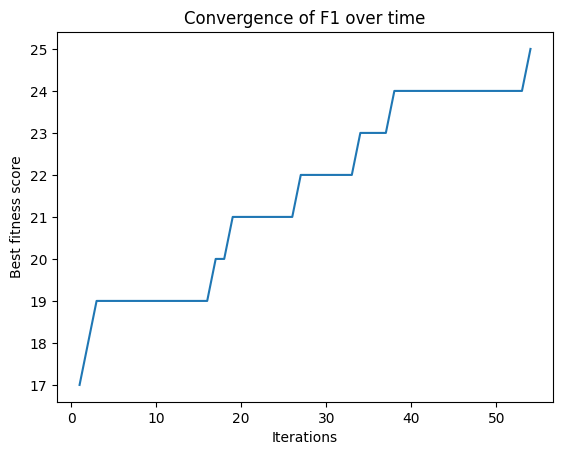

In [127]:
def F1(chromosome: int) -> int:
    return bin(chromosome).count('1')

variables, bits = 5, 5

opt, iter, scores = BGA(
    population_size          =100,
    crossover_probability =0.9,
    mutation_probability =0.01,
    max_iterations           =1000,
    fitness_function         =F1,
    variable_amount        =variables,
    variable_length          =bits,
     target_fitness            =25
)
print_results(opt, iter, scores, variables, bits, 'F1')

Running the same experiment with a given standard deviation threshold of $10^{-8}$, we can see that the algorithm has a harder time converging, but nevertheless finds it in an acceptable timeframe.

Global optimizer for F1 is [31, 31, 31, 31, 31], with fitness 25.0, found after 542 iterations.



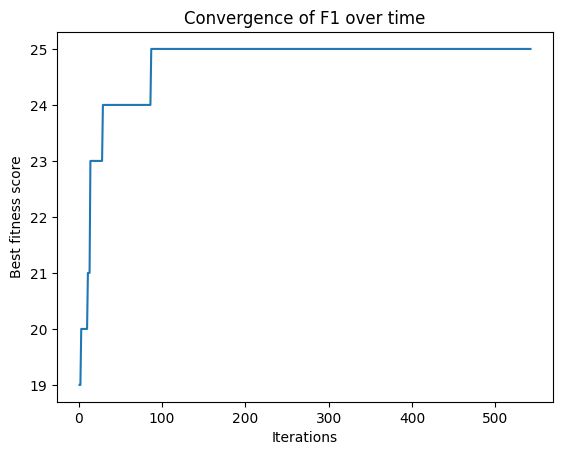

In [104]:
variables, bits = 5, 5

opt, iter, scores = BGA(
    population_size          =100,
    crossover_probability =0.9,
    mutation_probability =0.01,
    max_iterations           =1000,
    fitness_function         =F1,
    variable_amount        =variables,
    variable_length          =bits,
    target_std                   =0.00000001
)
print_results(opt, iter, scores, variables, bits, 'F1')

2) The second funtion 'F2' accepts a single variable and returns its square. 

While using it in the first instance, where the variable is of length 4 in bits, we notice that the algorithm converges instantaneously at the expected global best; this is natural, as the amount possible values of a 4-bit integer is 
\begin{align*}
    |\{0, 1\}^4| = 2^4 = 16
\end{align*}
and thus a population of size 100 is extremely likely to generate the global optimum randomly at the initialization phase.

Global optimizer for F2 is [15], with fitness 225.0, found after 41 iterations.



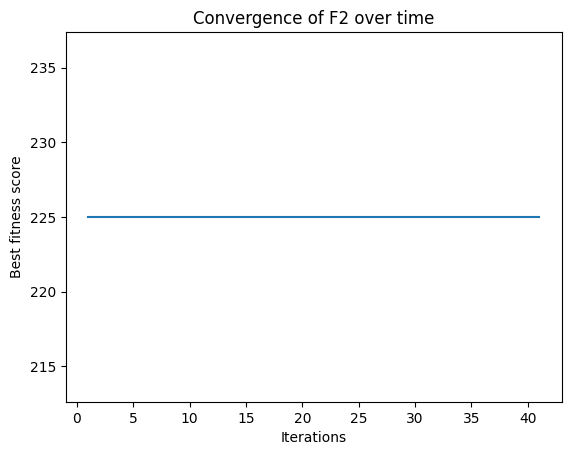

In [105]:
def F2(chromosome: int) -> int:
    return chromosome * chromosome

variables, bits = 1, 4

opt, iter, scores = BGA(
    population_size          =100,
    crossover_probability =0.9,
    mutation_probability =0.01,
    max_iterations           =1000,
    fitness_function         =F2,
    variable_amount        =variables,
    variable_length          =bits,
    target_std                   =0.00000001
)
print_results(opt, iter, scores, variables, bits, 'F2')

Gutting the population size to about 5 gives more interesting results; the algorithm finds it a greater challenge to converge to $15$ and may even miss it completely and 'camp' at a lesser, but still good, guess. It is equally likely that it will converge instantly once more, by sheer luck.

Global optimizer for F2 is [15], with fitness 225.0, found after 5 iterations.



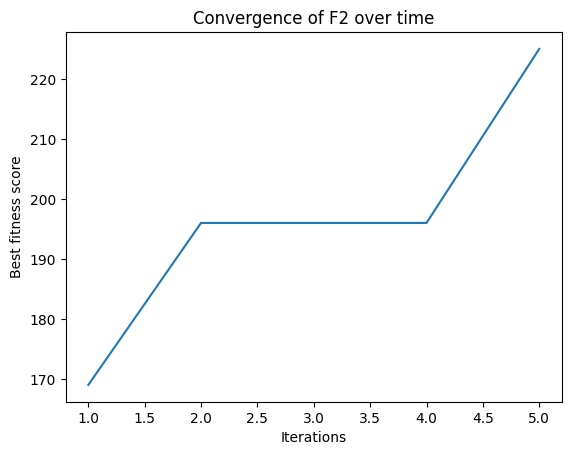

In [116]:
variables, bits = 1, 4

opt, iter, scores = BGA(
    population_size          =5,
    crossover_probability =0.9,
    mutation_probability =0.01,
    max_iterations           =1000,
    fitness_function         =F2,
    variable_amount        =variables,
    variable_length          =bits,
    target_fitness            =225
)
print_results(opt, iter, scores, variables, bits, 'F2')

Enlarging the input variable to length 10 bits also leads to more interesting results; the amount of possible values is now
\begin{align*}
    |\{0, 1\}^{10}| = 2^{10} = 1024
\end{align*}

so we can safely use the standard population size of 100.

By feeding the algorithm with the expected fitness of $1023^2$, we can see that it is has a very easy time finding the maximizer $1023$. The needed iterations are generally few and the plotline grows continuously.

Global optimizer for F2 is [1023], with fitness 1046529.0, found after 5 iterations.



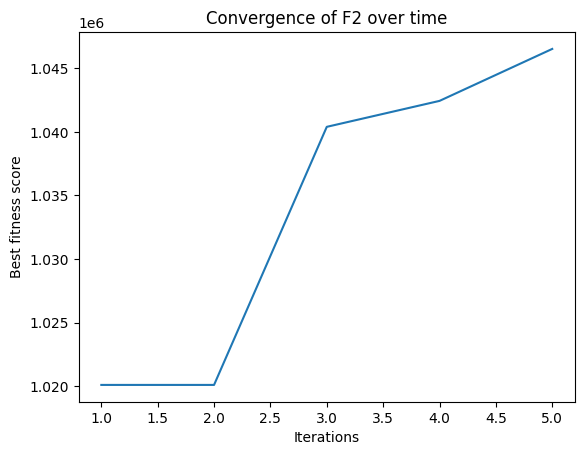

In [107]:
variables, bits = 1, 10

opt, iter, scores = BGA(
    population_size          =100,
    crossover_probability =0.9,
    mutation_probability =0.01,
    max_iterations           =1000,
    fitness_function         =F2,
    variable_amount        =variables,
    variable_length          =bits,
    target_fitness            =1023*1023
)
print_results(opt, iter, scores, variables, bits, 'F2')

The above hold true even with convergence with standard deviation. The above threshold of $10^{-8}$ slows the algorithm down only by a miniscule amount, and the entire population transforms into the global best in about 200 iterations.

Global optimizer for F2 is [1023], with fitness 1046529.0, found after 146 iterations.



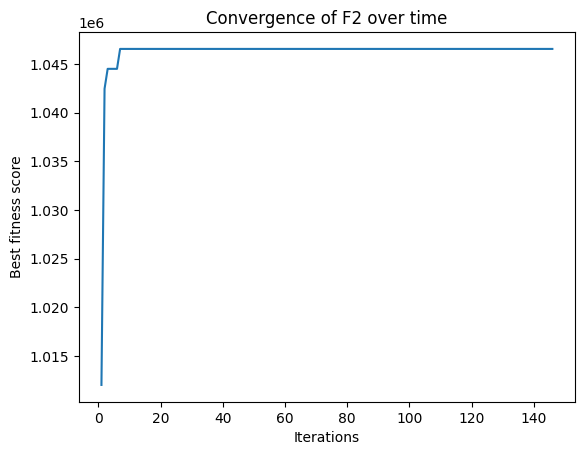

In [121]:
variables, bits = 1, 10

opt, iter, scores = BGA(
    population_size          =100,
    crossover_probability =0.9,
    mutation_probability =0.01,
    max_iterations           =1000,
    fitness_function         =F2,
    variable_amount        =variables,
    variable_length          =bits,
    target_std                   =0.00000001
)
print_results(opt, iter, scores, variables, bits, 'F2')

3) Finally, we are called to find a triple of integers that sum as close to 10 as possible; we, thus, want 

\begin{align*}
|x + y + z - 10| \rightarrow 0
\end{align*}

Since BGA maximizes by definition, we need to define 'F3' as

\begin{align*}
\frac{1}{|x + y + z - 10| + 1} \rightarrow 1
\end{align*}

which normalizes the above problem into a maximization one with a fitness ceiling of 1.

It happens that this function has many optima, and thus we can only use termination by standard deviation. Any solution that sums to 10 is acceptable.

Once again we can see that convergence is instantaneous. Here it happens because, as there are plenty optima to choose from, and the variable combinations are few, the algorithm is very likely to stumble upon a solution instantly by chance.


Global optimizer for F3 is [2, 7, 1], with fitness 1.0, found after 1000 iterations.



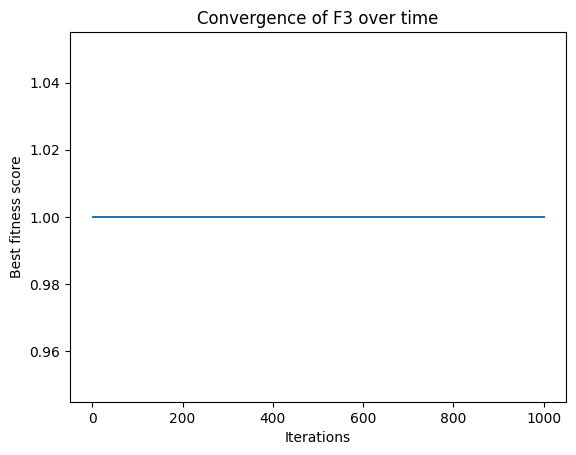

In [109]:
def F3(chromosome: int) -> float:
    binc = binary(chromosome, 9)
    x, y, z = wrap(binc, 3)
    return 1 / (abs(int(x, 2) + int(y, 2) + int(z, 2) - 10) + 1)

variables, bits = 3, 3

opt, iter, scores = BGA(
    population_size          =100,
    crossover_probability =0.9,
    mutation_probability =0.01,
    max_iterations           =1000,
    fitness_function         =F3,
    variable_amount        =variables,
    variable_length          =bits,
    target_std = 0.00000001               
)
print_results(opt, iter, scores, variables, bits, 'F3')

Let's make it interesting and allow each variable to be a byte in size. The new target sum is $763$. We allow the algorithm to run for the maximum amount of iterations, but we can still see that it converges surprisingly fast. The immense power of the BGA to solve such problems becomes evident.

Global optimizer for F3 is [254, 255, 254], with fitness 1.0, found after 1000 iterations.



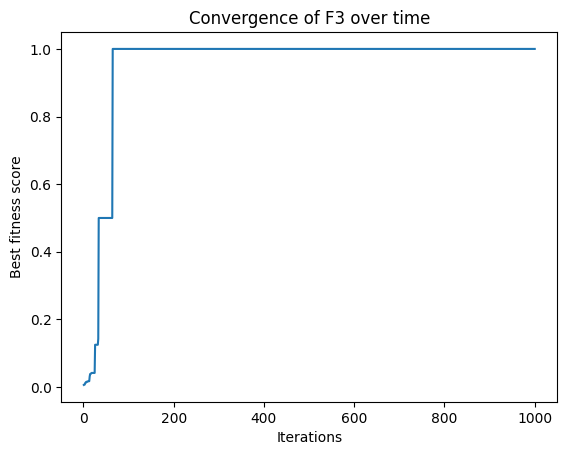

In [123]:
def F3(chromosome: int) -> float:
    binc = binary(chromosome, 24)
    x, y, z = wrap(binc, 8)
    return 1 / (abs(int(x, 2) + int(y, 2) + int(z, 2) - (3*255 - 2)) + 1)

variables = 3
bits = 8

opt, iter, scores = BGA(
    population_size          =50,
    crossover_probability =0.9,
    mutation_probability =0.01,
    max_iterations           =1000,
    fitness_function         =F3,
    variable_amount        =variables,
    variable_length          =bits
)
print_results(opt, iter, scores, variables, bits, 'F3')

<h3>$\begin{align*}References\end{align*}$</h3>

* *Engineering Optimization: Theory and Practice* by Singiresu S. Rao